In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
#import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.426131190105554 occ= 2
MO #4 (E1x #1), energy= -0.289938520612848 occ= 2
MO #5 (E1y #1), energy= -0.289938520612849 occ= 2
MO #6 (A1 #4), energy= -0.0349559135896397 occ= 0
MO #7 (A1 #5), energy= 0.664675049298746 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513672 occ= 0
MO #11 (A1 #7), energy= 1.57280313485608 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.2913277062506
Chemical Potential:  -0.16244721710124455
DFT trace:  7.124009715257126
Core eigvals:  [-4

Text(0.5, 1.0, 'Overlap Matrix Elements')

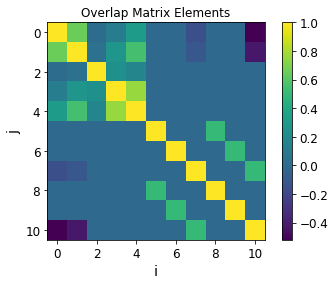

In [3]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
dft_mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
print('Chemical Potential: ', str(dft_mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
inv_ovlp = linalg.inv(ovlp)

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())
core_spect = linalg.eigvalsh(h1e, ovlp)
print("Core eigvals: ", core_spect)
num_electrons = 10
index = int(num_electrons/2)
gcp_mu = (core_spect[index] + core_spect[index-1])/2
plt.imshow(ovlp)
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.title('Overlap Matrix Elements')

In [4]:
beta = 3
num_steps = 10000
dbeta = beta/num_steps

# Perform GCP DMM method
identity = np.eye(h1e.shape[0])
dmm_gcp = gcp.non_linear_rk4(gcp.non_linear_rhs, ovlp/2, dbeta, h1e, inv_ovlp, identity, gcp_mu, num_steps, mf)

# Perform CP DMM method
init_rho = num_electrons*ovlp/ovlp.trace()
init_H = mf.get_veff(mf.mol, init_rho)
init_mu = (init_H.trace()+init_H.conj().T.trace())/(2*ovlp.trace())
dmm_cp, cp_mu, list_H = cp.non_linear_rk4(cp.non_linear_rhs, init_rho, dbeta, h1e, inv_ovlp, identity, num_steps, mf, num_electrons, ovlp, init_mu, 0)
print(cp_mu)
print(dmm_cp.trace())

3.0408013568652525
10.000000000000007


In [5]:
func_args = {'h1e': h1e, 'mf': mf, 'mu': gcp_mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp, 'beta': beta}
gcp_exact_P, norm_diff = gcp.aitkens(ovlp/2, 50, gcp.exact_single_step, **func_args)
func_args = {'h1e': h1e, 'mf': mf, 'mu': cp_mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp, 'beta': beta, 'num_electrons':num_electrons}
cp_exact_P, norm_diff = cp.aitkens(num_electrons*ovlp/ovlp.trace(), 100, cp.exact_single_step, **func_args)

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.8825258414953876
funm result may be inaccurate, approximate err = 0.8971905443259665
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.5051341163975186
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.7187401502342933
funm result ma

funm result may be inaccurate, approximate err = 6.856270909505108e-05
funm result may be inaccurate, approximate err = 2.079087734310888e-06
funm result may be inaccurate, approximate err = 2.507946935661169e-05
funm result may be inaccurate, approximate err = 2.2962214478951094e-06
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 3.917496683453558e-07
funm result may be inaccurate, approximate err = 3.855954097585071e-06
funm result may be inaccurate, approximate err = 5.354755151853143e-07
funm result may be inaccurate, approximate err = 0.0002421265293452757
funm result may be inaccurate, approximate err = 2.30940971830624e-06
funm result may be inaccurate, approximate err = 9.057065481559036e-05
funm result may be inaccurate, approximate err = 3.5476215893829977e-07
funm result may be inaccurate, approximate err = 2.5660969951727114e-06
funm result may be inaccurate, approximate err = 7.907019558230516e-08
funm result may be inacc

funm result may be inaccurate, approximate err = 9.21940828395762e-05
funm result may be inaccurate, approximate err = 7.787217283843035e-05
funm result may be inaccurate, approximate err = 0.000424836494247754
funm result may be inaccurate, approximate err = 0.00023071567512267433
funm result may be inaccurate, approximate err = 0.0014947587558593568
funm result may be inaccurate, approximate err = 3.26385115595048e-05
funm result may be inaccurate, approximate err = 0.03308354653070298
funm result may be inaccurate, approximate err = 0.0006370869575026469
funm result may be inaccurate, approximate err = 0.008141430678301049
funm result may be inaccurate, approximate err = 0.0006137651754672994
funm result may be inaccurate, approximate err = 0.14376454616848464
funm result may be inaccurate, approximate err = 0.003348767947142192
funm result may be inaccurate, approximate err = 0.027795408658839588
funm result may be inaccurate, approximate err = 0.18901560711657828
funm result may b

In [6]:
init_rho = num_electrons*ovlp/ovlp.trace()
norm_diff_temp = []
for i in range(100):
    temp_cp_exact_P = cp.exact_single_step(init_rho, **func_args)
    norm_diff_temp.append(linalg.norm(cp_exact_P - init_rho))
    init_rho = temp_cp_exact_P.copy()
    

funm result may be inaccurate, approximate err = 0.8845079617071612
funm result may be inaccurate, approximate err = 0.7053422403658001
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1.0517466126450038e-11
funm result may be inaccurate, approximate err = 8.373599653330349e-11
funm result may be inaccurate, approximate err = 6.790804078256977e-10
funm result may be inaccurate, approximate err = 3.799752496399929e-09
funm result may be inaccurate, approximate err = 4.105069164302304e-08
funm result may be inaccurate, approximate err = 2.3426850759467222e-07
funm result may be inaccurate, approximate err = 2.0493327294479915e-06
funm result may be inaccurate, approximate err = 1.963677198290865e-05
funm result may be inaccurate, approximate err = 0.00014601440949349941
funm result may be inaccurate, approximate err = 0.001140741709438397
funm result may be inaccurate, approximate err = 0.01119307751879219
funm result may be inaccurate, 

10.000000000000004
9.997819038789167


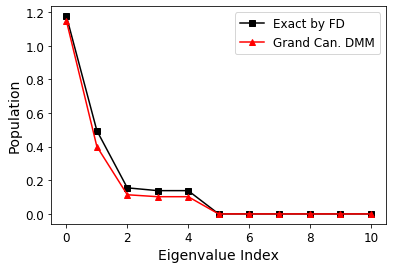

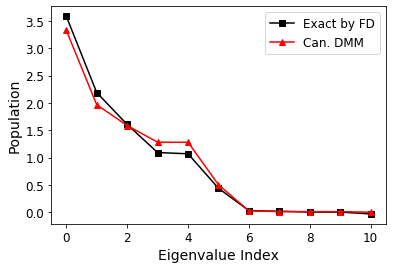

In [7]:
plt.figure(1)
plt.plot(linalg.eigvalsh(gcp_exact_P)[::-1], 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(dmm_gcp)[::-1], 'r^-', label="Grand Can. DMM")
plt.ylabel("Population")
plt.xlabel("Eigenvalue Index")
plt.legend(numpoints=1)
plt.savefig("gc_hf_eigs.png", format='png', dpi=300)

print(linalg.eigvalsh(dmm_cp).sum())
plt.figure(2)
plt.plot(linalg.eigvalsh(cp_exact_P)[::-1], 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(dmm_cp)[::-1], 'r^-', label="Can. DMM")
plt.ylabel("Population")
plt.xlabel("Eigenvalue Index")
#plt.plot(linalg.eigvalsh(temp_cp_exact_P, ovlp), 'g--', label="Simple")
plt.legend(numpoints=1)
plt.savefig("c_hf_eigs.png", format='png', dpi=300)
print(cp_exact_P.trace())

In [8]:
linalg.eigvalsh(dmm_cp, ovlp).sum()

7.565038145328428

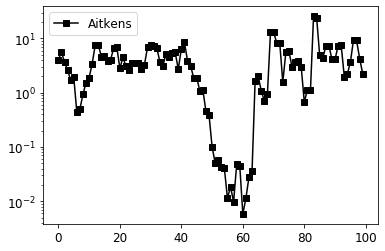

In [8]:
plt.semilogy(norm_diff, 'ks-', label="Aitkens")
#plt.semilogy(norm_diff_temp, 'rx-', label="Simple")
plt.legend(numpoints=1)

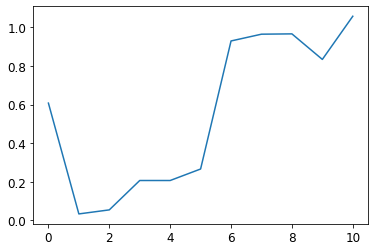

In [9]:
A = linalg.eigvalsh(cp_exact_P, ovlp)[::-1]
B = linalg.eigvalsh(dmm_cp, ovlp)[::-1]
plt.plot(np.abs(A-B)/np.abs(A))

[[ 3.20951375e+00  1.53290085e+00 -3.82246121e-01 -8.65994942e-03
   5.95208246e-01  1.00221203e-19  3.63286972e-19 -2.20677591e-01
   7.69498077e-19  1.94526203e-19 -1.41813962e+00]
 [ 1.53290085e+00  1.94331740e+00 -1.20837285e+00 -6.65462669e-02
   7.59610782e-01 -1.38029313e-18  1.63269902e-18 -2.18501672e-01
  -1.36252984e-18 -2.33455205e-18 -1.11722562e+00]
 [-3.82246121e-01 -1.20837285e+00 -2.45640096e+01 -5.97060560e+00
  -4.23224289e+00 -1.63562062e-18 -6.77626358e-19 -5.42533073e-02
   3.81905980e-19  7.06187250e-19 -7.32953758e-03]
 [-8.65994942e-03 -6.65462669e-02 -5.97060560e+00  1.97073237e-01
  -2.10771479e-01 -3.77103866e-18 -4.19391324e-18 -2.89949509e-01
  -2.69593620e-18 -9.37444098e-19 -1.61619083e-01]
 [ 5.95208246e-01  7.59610782e-01 -4.23224289e+00 -2.10771479e-01
   8.85311731e-01  4.81088244e-19 -2.14972992e-18 -2.47789535e-01
  -1.41330425e-19 -1.19920675e-18 -3.08202510e-01]
 [ 1.00221203e-19 -1.38029313e-18 -1.63562062e-18 -3.77103866e-18
   4.81088244e-19  

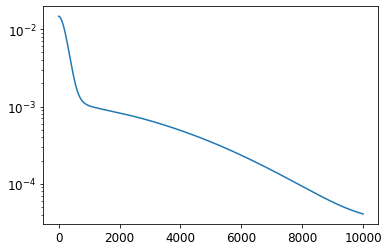

In [10]:
norm_diff_in_H = []
print(list_H[0])
for i in range(1, len(list_H)):
    norm_diff_in_H.append(linalg.norm(list_H[i]-list_H[i-1]))
plt.semilogy(norm_diff_in_H)